# Introduction
As introducted in the topic *[Pandas] Data Cleaning*, clean data is used as the input for analytical tasks. However, to build a good predictive model (in both performance and computation), a lot more works need to be done in order to improve data quality. These kind of tasks are called [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering), they get data into the appropriate format and reveal hidden insights. Feature engineering tasks are technically simple, but they do require some domain knowledge. This makes feature engineering more of an art than a science.

# 1. Data preprocessing

## 1.1. Scaling
Scaling is a preprocessing technique defined only on numerical variables, where the scaled variable distributes the same as the original one but does have specific properties.
- *Min-max scaling*: to have the min of $0$ and max of $1$
- *Standardization*: to have the mean of $0$ and standard deviation of $1$
- *Manhattan normalization*: to have the absolute values sum up to $1$
- *Euclidean normalization*: to have the squared values sum up to $1$

In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

### Min-max scaling
Many Machine Learning algorithms assume all variables are on the same scale, typically $[0;1]$. The formula for rescaling to $[a;b]$ is:

$$\mathbf{x}'=\frac{\mathbf{x}-\mathbf{x}_{min}}{\mathbf{x}_{max}-\mathbf{x}_{min}}(b-a)+a$$

In [7]:
df = pd.DataFrame({
    'x': [17, 22, 25, 30, 38],
    'y': [75, 81, 32, 23, 55]
})

scaler = MinMaxScaler(feature_range=(0,1))
dataScaled = scaler.fit_transform(df.values)
dfScaled = pd.DataFrame(dataScaled, columns=['x_scaled', 'y_scaled'])

df.join(dfScaled)

,x,y,x_scaled,y_scaled
0,17,75,0.000000,0.896552
1,22,81,0.238095,1.000000
2,25,32,0.380952,0.155172
3,30,23,0.619048,0.000000
4,38,55,1.000000,0.551724


### Standardization
Also called *z-score* scaling, it is a technique that transforms a variable so that it has a mean of $0$ and a standard deviation of $1$. Standardization is strongly recommended as the default method for data preprocessing. The formula for standardizing $x$ is:

$$\mathbf{x}'=\frac{\mathbf{x}-\mu_\mathbf{x}}{\sigma_\mathbf{x}}$$

In [9]:
df = pd.DataFrame({
    'x': [17, 22, 25, 30, 38],
    'y': [75, 81, 32, 23, 55]
})

scaler = StandardScaler()
dataScaled = scaler.fit_transform(df.values)
dfScaled = pd.DataFrame(dataScaled, columns=['x_scaled', 'y_scaled'])

df.join(dfScaled)

,x,y,x_scaled,y_scaled
0,17,75,-1.310622,0.953649
1,22,81,-0.613483,1.216121
2,25,32,-0.195199,-0.927401
3,30,23,0.501940,-1.321110
4,38,55,1.617363,0.078742


### Normalizing
This technique ensures the vector has a total length of 1. The length can be either Manhattan distance (L1) $\|\mathbf{x}\|_1 = |x_1|+|x_2|+\dots+|x_n|$ or Euclidean distance (L2) $\|\mathbf{x}\|_2 = \sqrt{x_1^2+x_2^2+\dots+x_n^2}$. The formula for normalizing is:

$$\mathbf{x}'=\frac{\mathbf{x}}{\|\mathbf{x}\|}$$

In [12]:
df = pd.DataFrame({
    'x': [17, 22, 25, 30, 38],
    'y': [75, 81, 32, 23, 55]
})

scaler = Normalizer(norm='l1')
dataScaled = scaler.fit_transform(df.values.T).T
dfScaled = pd.DataFrame(dataScaled, columns=['x_scaled', 'y_scaled'])

df.join(dfScaled)

,x,y,x_scaled,y_scaled
0,17,75,0.128788,0.281955
1,22,81,0.166667,0.304511
2,25,32,0.189394,0.120301
3,30,23,0.227273,0.086466
4,38,55,0.287879,0.206767


## 1.2. Transformation
Sometimes real world data distribute not very nice, while most transformation techiniques do not affect the distribution. Imagine the label in a regression problem is mostly small values, then Machine Learning algorithms will have a hard time *learning* higher values. By taking advantage of mathematical functions, Data Scientists can control the distribution of data to make them more *nature*.

In [58]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from feature_engine.transformation import LogCpTransformer, PowerTransformer
from feature_engine.transformation import BoxCoxTransformer, YeoJohnsonTransformer
from feature_engine.wrappers import SklearnTransformerWrapper

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

### Logarithm
This popular technique has the ability to make right skewed data distribute normally. The formula of the transformation is:

$$\mathbf{x}'=\log_b{(\mathbf{x}+c)}$$

Some notable tips when using 
<code style='font-size:13px'><a href='https://feature-engine.readthedocs.io/en/latest/api_doc/transformation/LogCpTransformer.html'>LogCpTransformer</a></code>:
- It works only on features contain all postive values.
- Different base values $b$ can be used, the most common ones are: $e$, $2$ and $10$.
- The term $c$ (usually $c=1$) is added to $\mathbf{x}$ to make sure the transformed values are all positive, since $\log{(x+1)}>\log1=0$.
- If the input values are very large, log transformation will not work. Thus, I insert a min-max scaler before it.

In [88]:
np.random.seed(7)
x = stats.skewnorm.rvs(a=4, loc=1, size=10000)
df = pd.DataFrame({'x': x})

transformer = make_pipeline(
    SklearnTransformerWrapper(MinMaxScaler()),
    LogCpTransformer(base='10', C=1),
)
dfTransformed = transformer.fit_transform(df)

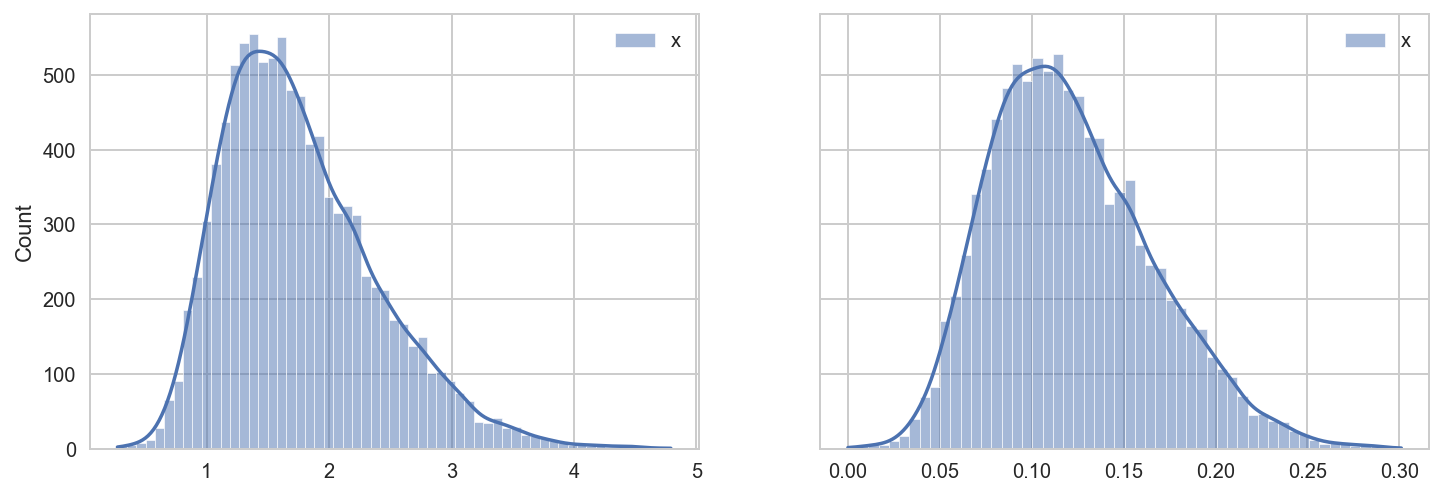

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
sns.histplot(df, ax=ax[0], kde=True, edgecolor='w')
sns.histplot(dfTransformed, ax=ax[1], kde=True, edgecolor='w')
plt.show()

### Box-Cox
[Box-Cox transform](https://en.wikipedia.org/wiki/Power_transform#Box–Cox_transformation) is a member of [power transform](https://en.wikipedia.org/wiki/Power_transform) family. It has the effect of making data more normal distribution-like. The transformation is given by a [piecewise function](https://en.wikipedia.org/wiki/Piecewise) as below:

$$
\mathbf{x}'=
\begin{cases}
    {\dfrac {\mathbf{x}^{\lambda}-1}{\lambda}}&{\text{if }}\lambda\neq 0\\
    \log\mathbf{x}&{\text{if }}\lambda=0
\end{cases}
$$

We implement this transformation via the class
<code style='font-size:13px;'><a href='https://feature-engine.readthedocs.io/en/latest/api_doc/transformation/BoxCoxTransformer.html'>BoxCoxTransformer</a></code>.
It wraps the function
<code style='font-size:13px;'><a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html'>scipy.stats.boxcox()</a></code>
which estimates the value of $\lambda$ that maximizes log-likelihood.

In [90]:
np.random.seed(7)
x = stats.skewnorm.rvs(a=4, loc=1, size=10000)
df = pd.DataFrame({'x': x})

transformer = BoxCoxTransformer()
dfTransformed = transformer.fit_transform(df)

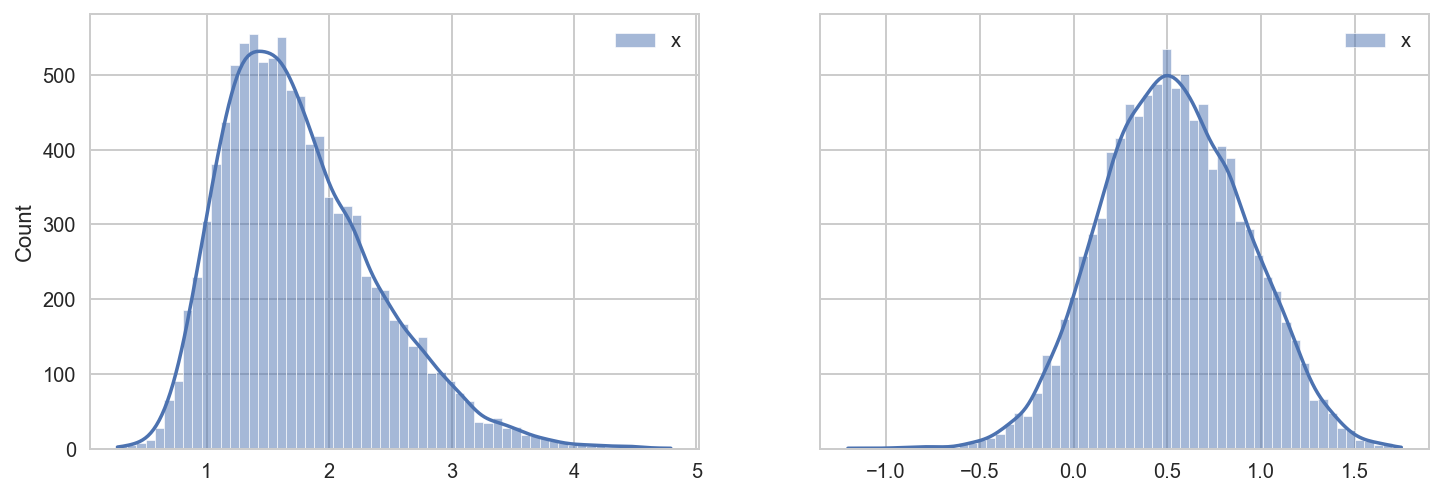

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
sns.histplot(df, ax=ax[0], kde=True, edgecolor='w')
sns.histplot(dfTransformed, ax=ax[1], kde=True, edgecolor='w')
plt.show()

### Yeo-Johnson
[Yeo-Johnson transform](https://en.wikipedia.org/wiki/Power_transform#Yeo–Johnson_transformation) is another member of power transform family. It extends Box-Cox transform to handle nagative input data, using the following function:

$$
\mathbf{x}'=
\begin{cases}
    \dfrac{(\mathbf{x}+1)^{\lambda}-1}{\lambda}       & \text{if }\lambda\neq 0\text{ and }\mathbf{x}\geq 0 \\
    \log(\mathbf{x}+1)                                & \text{if }\lambda=    0\text{ and }\mathbf{x}\geq 0 \\
    -\dfrac{(-\mathbf{x}+1)^{2-\lambda}-1}{2-\lambda} & \text{if }\lambda\neq 2\text{ and }\mathbf{x}\leq 0 \\
    -\log(-\mathbf{x}+1)                              & \text{if }\lambda=    0\text{ and }\mathbf{x}\geq 0 \\
\end{cases}
$$

It can be implemented via the class
<code style='font-size:13px;'><a href='https://feature-engine.readthedocs.io/en/latest/api_doc/transformation/YeoJohnsonTransformer.html'>YeoJohnsonTransformer</a></code>.

In [93]:
np.random.seed(7)
x = stats.skewnorm.rvs(a=4, loc=1, size=10000)
df = pd.DataFrame({'x': x})

transformer = YeoJohnsonTransformer()
dfTransformed = transformer.fit_transform(df)

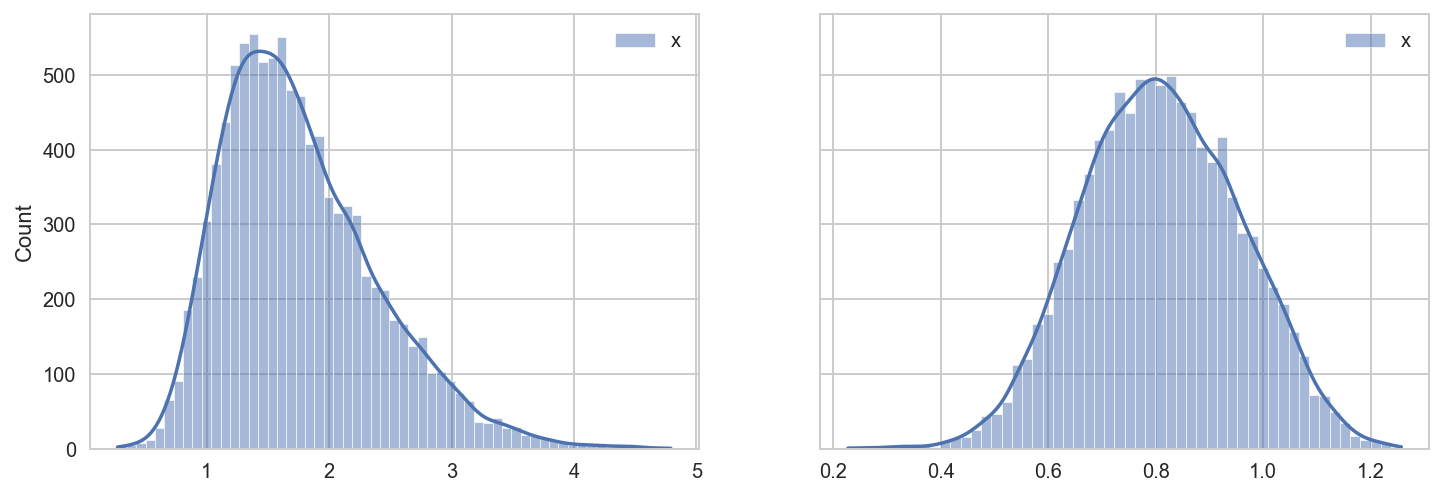

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
sns.histplot(df, ax=ax[0], kde=True, edgecolor='w')
sns.histplot(dfTransformed, ax=ax[1], kde=True, edgecolor='w')
plt.show()

## 1.2. Bucketizing
Bucketizing (or binning) refers to the tasks that put data into larger bins. Doing bucketizing means sacrifying information, however it makes data more regularized and thus prevents overfitting. Either numerical and categorical variables can be binned.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

### Discretizating

In [34]:
df = pd.DataFrame({'x': [17, 22, 25, 30, 38]})

group = pd.cut(
    df.x,
    bins=[0, 20, 30, 100],
    right=False,
    labels=['A', 'B', 'C'])

df.assign(group=group)

,x,group
0,17,A
1,22,B
2,25,B
3,30,C
4,38,C


### Clustering

In [48]:
np.random.seed(1)
df = pd.DataFrame({
    'x': np.random.randint(10, 100, size=10),
    'y': np.random.randint(10, 100, size=10)
})

clusterer = KMeans(3, random_state=0)
group = clusterer.fit_predict(df.values)

df.assign(group=group)

,x,y,group
0,47,86,2
1,22,81,2
2,82,16,1
3,19,35,0
4,85,60,1
5,15,30,0
6,89,28,1
7,74,94,2
8,26,21,0
9,11,38,0


### Mapping

In [2]:
df = pd.DataFrame({'x': ['England', 'France', 'Germany', 'Korea', 'Japan']})

x_map = df.x.map({
    'England': 'Europe', 'France': 'Europe', 'Germany': 'Europe',
    'Korea': 'Asia', 'Japan': 'Asia'
})

df.assign(x_map=x_map)

,x,x_map
0,England,Europe
1,France,Europe
2,Germany,Europe
3,Korea,Asia
4,Japan,Asia


## 1.3. Encoding
Encoding is the technique that transforms a categorical variable to numerical variable(s). This is important because most modern Machine Learning algorithms requires input features to be numerical.

For regression problems, OHE, sum encoding and Helmert encoding are usually used\
For classification problems, try OHE, LOO, and Target encoding. But for tree-base algorithms, avoid using OHE.

In [1]:
import numpy as np
import pandas as pd

### Ordinal encoding
<code style='font-size:13px'><a href='https://contrib.scikit-learn.org/category_encoders/ordinal.html'>OrdinalEncoder</a></code>
transforms categorical columns into unique numbers starting from 0. The disadvantage is that the categories are ordered randomly, which can add unexpected noises that hurt model performance. It also provides an option to pass a dictionary for custom order.

In [28]:
df = pd.DataFrame({
    'education': ['Highschool', 'Bachelor', 'Master', 'PhD']
})

In [28]:
from category_encoders.ordinal import OrdinalEncoder
encoder = OrdinalEncoder()
df['encodeEdu'] = encoder.fit_transform(df.education)
df

,education,encodeEdu
0,Highschool,1
1,Bachelor,2
2,Master,3
3,PhD,4


### One-hot encoding
<code style='font-size:13px'><a href='https://contrib.scikit-learn.org/category_encoders/onehot.html'>OneHotEncoder</a></code>
generates a binary feature for each category. This technique will expand the dataset which can lead to curse of dimensionality and over memory because of storing sparse data. A variant is sometimes used, call Dummy Encoding which cuts the last feature and encode the corresponding class using vectors of $0$.

In [24]:
df = pd.DataFrame({
    'x': ['Apple', 'Apple', 'Orange', 'Mango', 'Apple']
})

In [24]:
from category_encoders.one_hot import OneHotEncoder
encoder = OneHotEncoder(use_cat_names=True)
xEncoded = encoder.fit_transform(df.x)

df.join(xEncoded)

,x,x_Apple,x_Orange,x_Mango
0,Apple,1,0,0
1,Apple,1,0,0
2,Orange,0,1,0
3,Mango,0,0,1
4,Apple,1,0,0


### Sum encoding
<code style='font-size:13px'><a href='https://contrib.scikit-learn.org/category_encoders/sum.html'>SumEncoder</a></code> works nearly the same as Dummy Encoding, but it encodes vector of $-1$ for observations belonging to the last class rather than $0$.

In [5]:
df = pd.DataFrame({
    'education': ['Highschool', 'Bachelor', 'Bachelor', 'Master', 'Master', 'PhD', 'PhD'],
})

In [9]:
from category_encoders.sum_coding import SumEncoder
encoder = SumEncoder(['education'])
dfEncode = encoder.fit_transform(df.education)
dfEncode.join(df)

,intercept,education_0,education_1,education_2,education
0,1,1.0,0.0,0.0,Highschool
1,1,0.0,1.0,0.0,Bachelor
2,1,0.0,1.0,0.0,Bachelor
3,1,0.0,0.0,1.0,Master
4,1,0.0,0.0,1.0,Master
5,1,-1.0,-1.0,-1.0,PhD
6,1,-1.0,-1.0,-1.0,PhD


### Helmert encoding
<code style='font-size:13px'><a href='https://contrib.scikit-learn.org/category_encoders/helmert.html'>HelmertEncoder</a></code> is a target-based encoding method, with the following fashion:
- Ignore the first category that appears in the feature
- Start from the second category, compute the target mean of each class and sort from smallest to largest
- Create a feature for each category, in which we:
    - Encode $-1$ for all previous categories
    - Encode for that category the rank of itself
    - Encode $0$ otherwise

In [15]:
df = pd.DataFrame({
    'education': ['Highschool', 'PhD', 'Bachelor', 'Bachelor', 'Master', 'Master', 'Master', 'PhD', 'PhD'],
    'target': [0,1,0,0,1,1,0,1,1]
})
df.groupby('education')['target'].mean().sort_values()

education
Bachelor      0.000000
Highschool    0.000000
Master        0.666667
PhD           1.000000
Name: target, dtype: float64

In [16]:
from category_encoders.helmert import HelmertEncoder
encoder = HelmertEncoder(['education'])
dfEncode = encoder.fit_transform(df.education, df.target)
dfEncode.join(df)

,intercept,education_0,education_1,education_2,education,target
0,1,-1.0,-1.0,-1.0,Highschool,0
1,1,1.0,-1.0,-1.0,PhD,1
2,1,0.0,2.0,-1.0,Bachelor,0
3,1,0.0,2.0,-1.0,Bachelor,0
4,1,0.0,0.0,3.0,Master,1
5,1,0.0,0.0,3.0,Master,1
6,1,0.0,0.0,3.0,Master,0
7,1,1.0,-1.0,-1.0,PhD,1
8,1,1.0,-1.0,-1.0,PhD,1


### Frequency encoding

Frequency Encoding counts the number of a category’s occurrences in the dataset and assign it as the label. New categories in test dataset encoded with either *1* or counts of category in a test dataset, which makes this encoder return different results with different sizes of testing dataset

In [28]:
import pandas as pd

In [25]:
df = pd.DataFrame({
    'education': ['Highschool', 'Bachelor', 'Master', 'PhD', 'Master', 'PhD', 'PhD'],
    'target': [0,1,1,0,1,1,1]
})

freq = df.education.value_counts().to_dict()
df['encodeEdu'] = df.education.map(freq)
df

,education,target,encodeEdu
0,Highschool,0,1
1,Bachelor,1,1
2,Master,1,2
3,PhD,0,3
4,Master,1,2
5,PhD,1,3
6,PhD,1,3


### Target encoding

The most popular encoder used in kaggle competition. The main idea is using a blend between bayes probability of each category and prior probability of target to replace the categorical variable. On a binary classifier, the simplest way to do that is by calculating the probability $P(y = 1 | x = c_i)$ in which $y$ denotes the target, $x$ is the input and $c_i$ is the i-th category. This is considered the posterior probability of $y=1$ given the input was the category $c_i$.

For implementation, to avoid imbalance with minor categorical value, *category_encoders* add prior probability of target to calculate encode value

Disadvantage of this technique is it easily leads to overfitting due to *target leakage* - The model supposes to learn itself to discover the relationship between categorical variables and the target

In [10]:
import pandas as pd
from category_encoders.target_encoder import TargetEncoder

In [17]:
df = pd.DataFrame({
    'education': ['Highschool', 'Bachelor', 'Master', 'PhD', 'Master', 'PhD', 'PhD'],
    'target': [0,1,1,0,1,1,1]
})

encoder = TargetEncoder(smoothing=1,min_samples_leaf=0)

C:\Users\ADMIN\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [23]:
dfEncode = encoder.fit_transform(df.education, df.target)

In [24]:
dfEncode.rename(columns={'education':'encodeEdu'})\
.join(df)

,encodeEdu,education,target
0,0.714286,Highschool,0
1,0.714286,Bachelor,1
2,0.965942,Master,1
3,0.668925,PhD,0
4,0.965942,Master,1
5,0.668925,PhD,1
6,0.668925,PhD,1


### M-estimate encoding

This is a simplified version of target encoder, which also called m-probability estimate. In target encoder there are 2 hyperparameter: *min_sample_leaf* and *smoothing*, in M-estimate there is 1 hyperparameter which is $m$ - smoothing factor. Recommended values for $m$ is in range 1-100

$$e = \frac{N_{c_i|y=1} + \frac{N_{y=1}}{N} *m}{N_{y=1} + m}$$

In [1]:
import pandas as pd
from category_encoders.m_estimate import MEstimateEncoder

In [20]:
df = pd.DataFrame({
    'education': ['Highschool', 'Bachelor', 'Master', 'PhD', 'Master', 'PhD', 'PhD'],
    'target': [0,1,1,0,1,1,1]
})

encoder1 = MEstimateEncoder(m=0)
encoder2 = MEstimateEncoder(m=10)

In [21]:
dfEncode1 = encoder1.fit_transform(df.education, df.target)
dfEncode2 = encoder2.fit_transform(df.education, df.target)

In [22]:
dfEncode1.rename(columns={'education':'encodeEdu1'})\
.join(dfEncode2.rename(columns={'education':'encodeEdu2'}))\
.join(df)

,encodeEdu1,encodeEdu2,education,target
0,0.000000,0.649351,Highschool,0
1,1.000000,0.740260,Bachelor,1
2,1.000000,0.761905,Master,1
3,0.666667,0.703297,PhD,0
4,1.000000,0.761905,Master,1
5,0.666667,0.703297,PhD,1
6,0.666667,0.703297,PhD,1


### Weight Of Evidence Encoding

Weight Of Evidence (WOE) is a commonly used target-based encoder in credit scoring, it's formula is based on odds ratio but have some regularization to avoid target leakage:

$$\begin{align}
numerator = \frac{N_{c_i|y=1} + a}{N_{y=1} + 2a}\\
denominator = \frac{N_{c_i} - N_{c_i|y=1} + a}{N - N_{y=1} + 2a}\\
e = ln(\frac{numerator}{denominator})\\
\end{align}$$

In [29]:
import pandas as pd
from category_encoders.woe import WOEEncoder

In [30]:
df = pd.DataFrame({
    'education': ['Highschool', 'Bachelor', 'Master', 'PhD', 'Master', 'PhD', 'PhD'],
    'target': [0,1,1,0,1,1,1]
})

encoder = WOEEncoder(regularization=1)

In [31]:
dfEncode = encoder.fit_transform(df.education, df.target)

In [32]:
dfEncode.rename(columns={'education':'encodeEdu'})\
.join(df)

,encodeEdu,education,target
0,0.000000,Highschool,0
1,0.000000,Bachelor,1
2,0.538997,Master,1
3,-0.154151,PhD,0
4,0.538997,Master,1
5,-0.154151,PhD,1
6,-0.154151,PhD,1


### Leave-one-out Encoding

Leave-one-out Encoding is another example of target-based encoders. This encoder calculate mean target of category $c_i$ for observation $o_j$ if $o_j$ is removed from the dataset:

$$e_i = \frac{\sum y|c_i - y_i}{\sum y}$$

While encoding the test dataset, a category is replaced with the mean target of the category $c_i$ in the train dataset

In [33]:
import pandas as pd
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [34]:
df = pd.DataFrame({
    'education': ['Highschool', 'Bachelor', 'Master', 'PhD', 'Master', 'PhD', 'PhD'],
    'target': [0,1,1,0,1,1,1]
})

encoder = LeaveOneOutEncoder()

In [35]:
dfEncode = encoder.fit_transform(df.education, df.target)

In [36]:
dfEncode.rename(columns={'education':'encodeEdu'})\
.join(df)

,encodeEdu,education,target
0,0.714286,Highschool,0
1,0.714286,Bachelor,1
2,1.000000,Master,1
3,1.000000,PhD,0
4,1.000000,Master,1
5,0.500000,PhD,1
6,0.500000,PhD,1


# 2. Feature synthesis

Feature synthesis is the process of creating new features from 1 or many relative tables, this process is depend on domain knowledge of data scientist but it takes many times to do. Thus, automated feature engineering aims to help by automatically creating many candidate features out of a dataset from which the best can be selected and used for training. The feature creation process is grouping into 2 categories: *transformation* and *aggregation*

- A transformation acts on a single table by creating new features out of one or more of the existing columns, example extracting month from date or calculating log of a column.
- Aggregations are performed across tables, and use a one-to-many relationship to group observations and then calculate statistics. Example calculating mean of a feature from other table,...

[Featuretools](https://featuretools.alteryx.com/en/stable/) is the solution, this is open-source Python library will automatically create many features from a set of related tables. Then, the data scientist can choose a set of features that relative to the model by hand or by feature selection. There are 2 concept in featuretools: Entity (a single table) and EntitySet (a collection of tables and the relationships between them)

In [10]:
import numpy as np
import pandas as pd
import featuretools as ft
data = ft.demo.load_mock_customer()

In [9]:
dfTransaction = data['transactions'].merge(data['sessions']).merge(data['customers'])
dfTransaction.head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,birthday
0,298,1,2014-01-01 00:00:00,5,127.64,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
1,2,1,2014-01-01 00:01:05,2,109.48,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
2,308,1,2014-01-01 00:02:10,3,95.06,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
3,116,1,2014-01-01 00:03:15,4,78.92,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
4,371,1,2014-01-01 00:04:20,3,31.54,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18


In [11]:
dfProduct = data['products']
dfProduct.head()

,product_id,brand
0,1,B
1,2,B
2,3,B
3,4,B
4,5,A


Entityset: None
  DataFrames:
  Relationships:
    No relationships

In [13]:
# create an entity set, which is equivalent to a database
ft.EntitySet()

# add element and relationship
es = es.add_dataframe(
    dataframe=dfTransaction,
    dataframe_name='dfTrans',
    index='transaction_id'
)
es = es.add_dataframe(
    dataframe=dfProduct,
    dataframe_name='dfProd',
    index='product_id'
)
es = es.add_relationship(
    parent_dataframe_name='dfProd', parent_column_name='product_id',
    child_dataframe_name='dfTrans', child_column_name='product_id'
)

In [14]:
es['dfTrans'].head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,birthday
298,298,1,2014-01-01 00:00:00,5,127.64,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
2,2,1,2014-01-01 00:01:05,2,109.48,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
308,308,1,2014-01-01 00:02:10,3,95.06,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
116,116,1,2014-01-01 00:03:15,4,78.92,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
371,371,1,2014-01-01 00:04:20,3,31.54,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18


## 2.1. Synthesis within a table


In [6]:
es = ft.demo.load_mock_customer(return_entityset=True)

In [16]:
listPrim = ft.primitives.list_primitives()
listPrim[listPrim['type']=='transform'].head()[['name', 'type', 'description']]

,name,type,description
22,elmo,transform,Transforms a sentence or short paragraph using...
23,is_working_hours,transform,Determines if a datetime falls during working ...
24,num_characters,transform,Calculates the number of characters in a string.
25,part_of_day,transform,Determines the part of day of a datetime.
26,multiply_numeric,transform,Performs element-wise multiplication of two li...


In [18]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="dfTrans",
    trans_primitives=["hour",'cum_mean'],
    max_depth=2,
    ignore_columns = {'transactions':['session_id','customer_id','zip_code']}
)
feature_matrix

,session_id,product_id,amount,customer_id,device,zip_code,CUM_MEAN(amount),CUM_MEAN(customer_id),CUM_MEAN(session_id),HOUR(birthday),...,dfProd.NUM_UNIQUE(dfTrans.zip_code),dfProd.SKEW(dfTrans.amount),dfProd.SKEW(dfTrans.customer_id),dfProd.SKEW(dfTrans.session_id),dfProd.STD(dfTrans.amount),dfProd.STD(dfTrans.customer_id),dfProd.STD(dfTrans.session_id),dfProd.SUM(dfTrans.amount),dfProd.SUM(dfTrans.customer_id),dfProd.SUM(dfTrans.session_id)
transaction_id,,,,,,,,,,,,,,,,,,,,,
298,1,5,127.64,2,desktop,13244,127.640000,2.000000,1.000000,0,...,2,0.098248,0.168882,-0.099025,42.131902,1.474421,11.129005,7931.55,289.0,1914.0
2,1,2,109.48,2,desktop,13244,118.560000,2.000000,1.000000,0,...,2,0.151934,-0.018901,0.042049,46.336308,1.424774,9.391642,7021.43,271.0,1571.0
308,1,3,95.06,2,desktop,13244,110.726667,2.000000,1.000000,0,...,2,0.223938,-0.058031,-0.126098,38.871405,1.341273,10.703336,7008.12,291.0,1832.0
116,1,4,78.92,2,desktop,13244,102.775000,2.000000,1.000000,0,...,2,-0.132077,0.372178,0.013343,42.492501,1.440556,9.942765,8088.97,273.0,1894.0
371,1,3,31.54,2,desktop,13244,88.528000,2.000000,1.000000,0,...,2,0.223938,-0.058031,-0.126098,38.871405,1.341273,10.703336,7008.12,291.0,1832.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,35,5,55.42,3,mobile,13244,75.253790,2.842742,17.903226,0,...,2,0.098248,0.168882,-0.099025,42.131902,1.474421,11.129005,7931.55,289.0,1914.0
111,35,3,34.87,3,mobile,13244,75.172535,2.843058,17.937626,0,...,2,0.223938,-0.058031,-0.126098,38.871405,1.341273,10.703336,7008.12,291.0,1832.0
276,35,1,10.94,3,mobile,13244,75.043554,2.843373,17.971888,0,...,2,0.125525,-0.054764,0.036985,42.479989,1.404986,10.640783,7489.79,298.0,1809.0


## 2.2. Aggregating across tables

In [20]:
listPrim = ft.primitives.list_primitives()
listPrim.head()

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,num_unique,aggregation,True,True,"Determines the number of distinct values, igno...",<ColumnSchema (Semantic Tags = ['category'])>,<ColumnSchema (Logical Type = IntegerNullable)...
1,percent_true,aggregation,True,False,Determines the percent of `True` values.,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Logical Type = Double) (Semanti...
2,max,aggregation,True,True,"Calculates the highest value, ignoring `NaN` v...",<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
3,n_most_common,aggregation,False,False,Determines the `n` most common elements.,<ColumnSchema (Semantic Tags = ['category'])>,None
4,any,aggregation,True,False,Determines if any value is 'True' in a list.,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Logical Type = Boolean)>


In [24]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="transactions",
    trans_primitives=["hour",'cum_mean'],
    agg_primitives=['sum','mean','count','std'],
    max_depth=4,
    ignore_columns = {'transactions':['session_id','customer_id','zip_code']}
)

feature_defs

[<Feature: product_id>,
 <Feature: amount>,
 <Feature: device>,
 <Feature: CUM_MEAN(amount)>,
 <Feature: HOUR(birthday)>,
 <Feature: HOUR(join_date)>,
 <Feature: HOUR(session_start)>,
 <Feature: HOUR(transaction_time)>,
 <Feature: products.COUNT(transactions)>,
 <Feature: products.MEAN(transactions.amount)>,
 <Feature: products.STD(transactions.amount)>,
 <Feature: products.SUM(transactions.amount)>,
 <Feature: products.MEAN(transactions.CUM_MEAN(amount))>,
 <Feature: products.STD(transactions.CUM_MEAN(amount))>,
 <Feature: products.SUM(transactions.CUM_MEAN(amount))>,
 <Feature: products.CUM_MEAN(COUNT(transactions))>,
 <Feature: products.CUM_MEAN(MEAN(transactions.amount))>,
 <Feature: products.CUM_MEAN(STD(transactions.amount))>,
 <Feature: products.CUM_MEAN(SUM(transactions.amount))>,
 <Feature: products.CUM_MEAN(MEAN(transactions.CUM_MEAN(amount)))>,
 <Feature: products.CUM_MEAN(STD(transactions.CUM_MEAN(amount)))>,
 <Feature: products.CUM_MEAN(SUM(transactions.CUM_MEAN(amount)))>

In [25]:
from featuretools import selection

In [26]:
fm, new_ft = selection.remove_low_information_features(feature_matrix, feature_defs)

In [27]:
print(feature_matrix.shape)
print(fm.shape)

(500, 22)
(500, 21)


In [28]:
# drop ft
set(feature_defs) - set(new_ft)

{<Feature: HOUR(birthday)>}

In [29]:
selection.remove_highly_correlated_features(fm)

,product_id,amount,device,CUM_MEAN(amount),HOUR(join_date),HOUR(session_start),HOUR(transaction_time),products.COUNT(transactions),products.MEAN(transactions.amount),products.STD(transactions.amount),products.SUM(transactions.amount),products.MEAN(transactions.CUM_MEAN(amount)),products.STD(transactions.CUM_MEAN(amount)),products.CUM_MEAN(COUNT(transactions)),products.CUM_MEAN(MEAN(transactions.amount)),products.CUM_MEAN(STD(transactions.amount)),products.CUM_MEAN(SUM(transactions.amount)),products.CUM_MEAN(MEAN(transactions.CUM_MEAN(amount)))
transaction_id,,,,,,,,,,,,,,,,,,
298,5,127.64,desktop,127.640000,23,0,0,104,76.264904,42.131902,7931.55,78.432521,5.449310,100.000000,75.065279,42.462421,7507.972000,78.323170
2,2,109.48,desktop,118.560000,23,0,0,92,76.319891,46.336308,7021.43,78.718486,5.005781,97.000000,74.874603,44.408148,7255.610000,78.289505
308,3,95.06,desktop,110.726667,23,0,0,96,73.001250,38.871405,7008.12,78.438940,4.277017,96.666667,74.250152,42.562567,7173.113333,78.339317
116,4,78.92,desktop,102.775000,23,0,0,106,76.311038,42.492501,8088.97,78.165378,3.502280,99.000000,74.765373,42.545051,7402.077500,78.295832
371,3,31.54,desktop,88.528000,23,0,0,96,73.001250,38.871405,7008.12,78.438940,4.277017,96.666667,74.250152,42.562567,7173.113333,78.339317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,5,55.42,mobile,75.253790,15,8,8,104,76.264904,42.131902,7931.55,78.432521,5.449310,100.000000,75.065279,42.462421,7507.972000,78.323170
111,3,34.87,mobile,75.172535,15,8,8,96,73.001250,38.871405,7008.12,78.438940,4.277017,96.666667,74.250152,42.562567,7173.113333,78.339317
276,1,10.94,mobile,75.043554,15,8,8,102,73.429314,42.479989,7489.79,77.860524,2.003768,102.000000,73.429314,42.479989,7489.790000,77.860524


# 3. Pipeline
A data science project has multiple steps of getting data, cleaning, transforming, modeling and evalutating. To make the complicated process to become easier, Scikit-learn provides the [pipeline](https://scikit-learn.org/stable/modules/compose.html) module. The purpose of the pipeline is to assemble several steps sequentially and can be reused for different datasets in the future.

## 3.1. Data preprocessing

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

In [2]:
dfTitanic = pd.read_csv('data/titanic_train.csv')

x = dfTitanic.drop(columns='Survived')
y = dfTitanic.Survived

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=7)

In [3]:
xTrain.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
205,206,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S
718,719,3,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q
835,836,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,E49,C
851,852,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S
773,774,3,"Elias, Mr. Dibo",male,NaN,0,0,2674,7.2250,NaN,C


### Simple pipeline
A simple preprocesing pipeline applies transformers to all columns. Provided via the class
<code style='font-size:13px'><a href='https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html'>Pipeline</a></code>,
the main component we would care about is the steps, which is constructed using a list of tuples with the signature
<code style='font-size:13px'>(name, transformer)</code>.

In [4]:
trans = Pipeline([
    ('Impute', SimpleImputer(strategy='mean')),
    ('Scale', StandardScaler()),
])

trans.fit_transform(xTrain[['Age', 'Fare']])

array([[-2.1265, -0.431 ],
       [-0.    , -0.3352],
       [ 0.7519,  0.951 ],
       ...,
       [ 0.0518,  1.3934],
       [-0.    , -0.4826],
       [-0.8818, -0.4806]])

### Column transformer
The problem arises when we would probably want to apply diffrent pipelines to different subsets of features such as categorical and numerical. To tackle this, Scikit-learn provides the class
<code style='font-size:13px'><a href='https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html'>ColumnTransformer</a></code>
which accepts a list of tuples with the signature
<code style='font-size:13px'>(name, transformer, columns)</code>.

We can use any Scikit-learn's transformer stand alone as well as a pipeline. To specify columns, the best practice is using column names, but the class also accepts column indices. Also note that if a feature appears in different steps, only the first step takes effect.

In [5]:
name1 = 'Categorical1'
cols1 = ['Ticket', 'Cabin']
trans1 = Pipeline([
    ('Impute', SimpleImputer(strategy='constant')),
    ('Encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

name2 = 'Categorical2'
cols2 = ['Sex', 'Embarked']
trans2 = OneHotEncoder(handle_unknown='ignore')

name3 = 'Numerical'
cols3 = ['Age', 'Fare']
trans3 = Pipeline([
    ('Impute', KNNImputer(n_neighbors=5)),
    ('Scale', StandardScaler()),
    ('Transform', FunctionTransformer(lambda x: np.exp(x)))
])

name4 = 'Integer'
cols4 = ['Pclass', 'SibSp', 'Parch']
trans4 = 'passthrough'

name5 = 'Unique'
cols5 = ['PassengerId', 'Name']
trans5 = 'drop'

In [6]:
trans = ColumnTransformer([
    (name1, trans1, cols1),
    (name2, trans2, cols2),
    (name3, trans3, cols3),
    (name4, trans4, cols4),
    (name5, trans5, cols5),
])

trans.fit(xTrain)
trans

ColumnTransformer(transformers=[('Categorical1',
                                 Pipeline(steps=[('Impute',
                                                  SimpleImputer(strategy='constant')),
                                                 ('Encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Ticket', 'Cabin']),
                                ('Categorical2',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Sex', 'Embarked']),
                                ('Numerical',
                                 Pipeline(steps=[('Impute', KNNImputer()),
                                                 ('Scale', StandardScaler()),
                                                 ('Transform',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fd2ee59ed30>))]),
                                 ['Age', 'Fare']),
                                ('Integer', 'passthrough',
                                 ['Pclass', 'SibSp', 'Parch']),
                                ('Unique', 'drop', ['PassengerId', 'Name'])])

In [7]:
trans.transform(xTest)

array([[ -1., 126.,   0., ...,   3.,   0.,   0.],
       [ -1., 126.,   0., ...,   2.,   1.,   0.],
       [ -1., 126.,   0., ...,   3.,   0.,   0.],
       ...,
       [ -1., 126.,   0., ...,   3.,   0.,   0.],
       [ -1., 126.,   0., ...,   3.,   0.,   0.],
       [475., 126.,   1., ...,   2.,   1.,   0.]])

## 3.2. Modeling
A <code style='font-size:13px'>Pipeline</code> is very useful for data preprocessing, but it can also be used for modeling.

In [8]:
import datetime as dt
import numpy as np
import pandas as pd
from scipy import stats
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score as AUC

In [9]:
dfTitanic = pd.read_csv('data/titanic_train.csv')

x = dfTitanic.drop(columns='Survived')
y = dfTitanic.Survived

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=7)

In [10]:
xTrain.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
205,206,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S
718,719,3,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q
835,836,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,E49,C
851,852,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S
773,774,3,"Elias, Mr. Dibo",male,NaN,0,0,2674,7.2250,NaN,C


In [11]:
name1 = 'Categorical1'
cols1 = ['Ticket', 'Cabin']
trans1 = Pipeline([
    ('Impute', SimpleImputer(strategy='constant')),
    ('Encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

name2 = 'Categorical2'
cols2 = ['Sex', 'Embarked']
trans2 = OneHotEncoder(handle_unknown='ignore')

name3 = 'Numerical'
cols3 = ['Age', 'Fare']
trans3 = Pipeline([
    ('Impute', KNNImputer(n_neighbors=5)),
    ('Scale', StandardScaler()),
])

name4 = 'Integer'
cols4 = ['Pclass', 'SibSp', 'Parch']
trans4 = 'passthrough'

name5 = 'Unique'
cols5 = ['PassengerId', 'Name']
trans5 = 'drop'

### Grid search

In [12]:
trans = ColumnTransformer([
    (name1, trans1, cols1),
    (name2, trans2, cols2),
    (name3, trans3, cols3),
    (name4, trans4, cols4),
    (name5, trans5, cols5),
])

modelRf = RandomForestClassifier(random_state=7)

pipe = Pipeline([
    ('Transformer', trans),
    ('ModelRF', modelRf)
])
pipe

Pipeline(steps=[('Transformer',
                 ColumnTransformer(transformers=[('Categorical1',
                                                  Pipeline(steps=[('Impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('Encode',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Ticket', 'Cabin']),
                                                 ('Categorical2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Embarked']),
                                                 ('Numerical',
                                                  Pipeline(steps=[('Impute',
                                                                   KNNImputer()),
                                                                  ('Scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('Integer', 'passthrough',
                                                  ['Pclass', 'SibSp', 'Parch']),
                                                 ('Unique', 'drop',
                                                  ['PassengerId', 'Name'])])),
                ('ModelRF', RandomForestClassifier(random_state=7))])

Now we have prepare a pipeline, let's see how to use it with grid search. We have already known grid search is used to find the best hyperparameters of a model, but when coming with pipeline, it can also be used to search for the best configurations of preprocessing steps.

In [13]:
start = dt.datetime.now()

params = {
    'Transformer__Numerical__Impute__n_neighbors': [3, 5, 7],
    'ModelRF__n_estimators': [30, 50, 70],
    'ModelRF__max_features': [0.4, 0.6],
    'ModelRF__max_samples': [0.4, 0.6],
}
validator = GridSearchCV(pipe, params, cv=5, scoring='roc_auc')
validator = validator.fit(xTrain, yTrain)

print(dt.datetime.now() - start)

0:00:16.232052


In [14]:
validator.best_params_

{'ModelRF__max_features': 0.4,
 'ModelRF__max_samples': 0.4,
 'ModelRF__n_estimators': 70,
 'Transformer__Numerical__Impute__n_neighbors': 5}

In [15]:
yTestPred = validator.predict_proba(xTest)[:, 1]
auc = AUC(yTest, yTestPred)
modelName = validator.best_estimator_.steps[1][1].__class__.__name__
print(f'AUC = {auc:.4f} [{modelName}]')

AUC = 0.7995 [RandomForestClassifier]


### Model selection
To adapt pipeline to select among multiple Machine Learning algorithms, we need some tricks.

In [16]:
trans = ColumnTransformer([
    (name1, trans1, cols1),
    (name2, trans2, cols2),
    (name3, trans3, cols3),
    (name4, trans4, cols4),
    (name5, trans5, cols5),
])

pipe = Pipeline([
    ('Transformer', trans),
    ('Model', RandomForestClassifier())
])

In [17]:
start = dt.datetime.now()

params = [
    {
        'Transformer__Numerical__Impute__n_neighbors': [5, 7],
        'Model': [RandomForestClassifier()],
        'Model__n_estimators': [80, 100],
        'Model__max_samples': [0.3, 0.5],
    },
    {
        'Transformer__Numerical__Impute__n_neighbors': [5, 7],
        'Model': [HistGradientBoostingClassifier()],
        'Model__max_iter': [80, 100],
        'Model__learning_rate': [0.1, 0.05],
    }
]

validator = GridSearchCV(pipe, params, cv=5, scoring='roc_auc')
validator = validator.fit(xTrain, yTrain)

print(dt.datetime.now() - start)

0:00:21.043318


In [18]:
validator.best_params_

{'Model': HistGradientBoostingClassifier(learning_rate=0.05),
 'Model__learning_rate': 0.05,
 'Model__max_iter': 100,
 'Transformer__Numerical__Impute__n_neighbors': 5}

In [19]:
yTestPred = validator.predict_proba(xTest)[:, 1]
auc = AUC(yTest, yTestPred)
modelName = validator.best_estimator_.steps[1][1].__class__.__name__
print(f'AUC = {auc:.4f} [{modelName}]')

AUC = 0.8102 [HistGradientBoostingClassifier]


### Saving a model
The built-in package [Pickle](https://docs.python.org/3/library/pickle.html) in python let us save the model into a file and load it again to make prediction. This helps us saving the time to train the model from the begin each time we use it. In case the model is too big, [Joblib](https://joblib.readthedocs.io/en/latest/) is a good alternative. The extension of pickle files can be anything, but is usually
<code style='font-size:13px'>.p</code>
<code style='font-size:13px'>.pkl</code>
<code style='font-size:13px'>.pickle</code>
as Pickle uses Pickle protocol to read the data inside the file and ignores the extension. 

In [20]:
import pickle
filename = 'output/pipeline_model.pkl'

pickle.dump(validator, open(filename, 'wb'))

modelLoaded = pickle.load(open(filename, 'rb'))

yTestPred = modelLoaded.predict_proba(xTest)[:, 1]
auc = AUC(yTest, yTestPred)
modelName = modelLoaded.best_estimator_.steps[1][1].__class__.__name__
print(f'AUC = {auc:.4f} [{modelName}]')

AUC = 0.8102 [HistGradientBoostingClassifier]


In [22]:
import joblib
filename = 'output/pipeline_model.joblib'

joblib.dump(validator, filename)

modelLoaded = joblib.load(filename)

yTestPred = modelLoaded.predict_proba(xTest)[:, 1]
auc = AUC(yTest, yTestPred)
modelName = modelLoaded.best_estimator_.steps[1][1].__class__.__name__
print(f'AUC = {auc:.4f} [{modelName}]')

AUC = 0.8102 [HistGradientBoostingClassifier]


# References

- *featuretools.alteryx.com - [Documentation](https://featuretools.alteryx.com/en/stable/)*
- *contrib.scikit-learn.org - [Category encoders](https://contrib.scikit-learn.org/category_encoders/)*
- *kaggle.com - [11 categorical encoders and benchmarks](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark)*
- *kaggle.com - [Automated feature engineering basics](https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-basics/notebook#Deep-Feature-Synthesis)*
- *towardsdatascience.com - [Benchmarking categorical encoders](https://towardsdatascience.com/benchmarking-categorical-encoders-9c322bd77ee8)*
- *towardsdatascience.com - [Automated feature engineering in Python](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219)*

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*